# About

- this notebook was developed to Business Process Intelligence Challenge '2020
- report is posted on BPIC

Authors:
- Mikhail Poruchikov, mporuchikov@gmail.com
- Pavel Katkov, katkov.p.i@gmail.com

# Abstract

Every day companies all over the world try to improve efficiency of their business processes. In this report we analyze travel data supplied by Eindhoven University of Technology. Due to specific nature of data, represented as event logs, we used process mining, a technique that allows to discover real behavior of a system, as well as more traditional statistical analysis. To build as-is model of a process we used PM4Py, open source process mining platform. During research many outliers and bottlenecks were found. In this report we describe results of research and make suggestions that allow to make the process of managing travels at Eindhoven University of Technology more efficient.

# Keywords

- Business Process Intelligence
- Process Mining
- Process Discovery
- Event Logs
- PM4Pym

# 1 Introduction

## 1.2 Problem

The following questions are of interest:

- What is the throughput of a travel declaration from submission (or closing) to paying?
- Is there are difference in throughput between national and international trips?
- Are there differences between clusters of declarations, for example between cost centers/departments/projects etc.?
- What is the throughput in each of the process steps, i.e. the submission, judgement by various responsible roles and payment?
- Where are the bottlenecks in the process of a travel declaration?
- Where are the bottlenecks in the process of a travel permit (note that there can be mulitple requests for payment and declarations per permit)?
- How many travel declarations get rejected in the various processing steps and how many are never approved?

Then there are more detailed questions

- How many travel declarations are booked on projects?
- How many corrections have been made for declarations?
- Are there any double payments?
- Are there declarations that were not preceded properly by an approved travel permit? Or are there even declarations for which no permit exists?
- How many travel declarations are submitted by the traveler and how many by a mandated person?
- How many travel declarations are first rejected because they are submitted more than 2 months after the end of a trip and are then re-submitted?
- Is this different between departments?
- How many travel declarations are not approved by budget holders in time (7 days) and are then automatically rerouted to supervisors?
- Next to travel declarations, there are also requests for payments. These are specific for non-TU/e employees. Are there any TU/e employees that submitted a request for payment instead of a travel declaration?
 

We are aware that not all questions can be answered on this dataset and we encourage the participants to come up with new and interesting insights.

# 2 Methods

## 2.1 Exploratory Data Analysis

*Lets take a look at data. Data is supplied as files in XES format.*

In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, linregress
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
import matplotlib.pyplot as plt
%matplotlib inline

### Domestic Declarations

In [2]:
log_dom_decl = xes_importer.apply('../data/DomesticDeclarations.xes_')

*Since we are using Python it is convenient to transform log to pandas dataframe.*

In [3]:
df_dom_decl = log_converter.apply(log_dom_decl, variant=log_converter.Variants.TO_DATA_FRAME)
df_dom_decl.shape

(56437, 10)

*Let's count number of activities in each declaration*

In [4]:
x = df_dom_decl['case:id'].value_counts().values
x.min(), x.max(), len(x)

(1, 24, 10500)

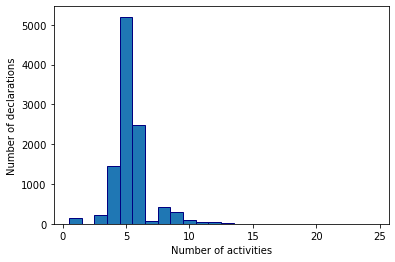

In [5]:
fig, ax = plt.subplots()
#ax.hist(x, bins=24, range=(1,25), histtype='bar', edgecolor='black', linewidth=1, facecolor='0.9', align='left')
ax.hist(x, bins=24, range=(1,25), histtype='bar', edgecolor='navy', linewidth=1, align='left')
plt.xlabel("Number of activities")
plt.ylabel("Number of declarations")
plt.show()
fig.savefig('../figures/histogram-n_act-n_cases-domestic-800dpi.png', dpi=800, bbox_inches='tight')

*Number of declarations with single activity*

In [6]:
df_dom_decl['case:id'].value_counts().value_counts()[1]

134

### International Declarations

In [7]:
log_int_decl = xes_importer.apply('../data/InternationalDeclarations.xes_')

In [8]:
df_int_decl = log_converter.apply(log_int_decl, variant=log_converter.Variants.TO_DATA_FRAME)
df_int_decl.shape

(72151, 23)

In [9]:
x = df_int_decl['case:id'].value_counts().values
x.min(), x.max(), len(x)

(3, 27, 6449)

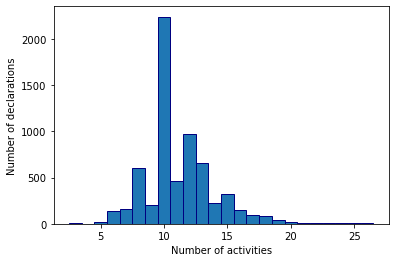

In [10]:
fig, ax = plt.subplots()
ax.hist(x, bins=24, range=(3,27), histtype='bar', edgecolor='navy', linewidth=1, align='left')
plt.xlabel("Number of activities")
plt.ylabel("Number of declarations")
plt.show()
fig.savefig('../figures/histogram-n_act-n_cases-international-800dpi.png', dpi=800, bbox_inches='tight')

## Q02
Is there are difference in throughput between national and international trips?

*Lets compute duration of each declaration for both domestic and international declarations using Python's pandas library.*

In [11]:
df_dom_decl['dt'] = pd.to_datetime(df_dom_decl['time:timestamp'], utc=True)
df1 = df_dom_decl[['case:id', 'dt']].groupby('case:id').agg(['min', 'max'])
df1['days'] = (df1['dt']['max'] - df1['dt']['min']).dt.total_seconds() / 86400

In [12]:
df1.head()

dt                            \
                                         min                       max   
case:id                                                                  
declaration 100000 2018-01-30 08:20:07+00:00 2018-02-12 16:31:20+00:00   
declaration 100005 2018-01-30 08:38:54+00:00 2018-02-01 16:31:17+00:00   
declaration 100010 2018-01-30 08:43:21+00:00 2018-02-01 16:31:17+00:00   
declaration 100015 2018-01-30 12:06:43+00:00 2018-02-05 16:31:02+00:00   
declaration 100021 2018-01-31 10:05:55+00:00 2018-02-12 16:31:20+00:00   

                         days  
                               
case:id                        
declaration 100000  13.341123  
declaration 100005   2.328044  
declaration 100010   2.324954  
declaration 100015   6.183553  
declaration 100021  12.267650

In [13]:
df_int_decl['dt'] = pd.to_datetime(df_int_decl['time:timestamp'], utc=True)
df2 = df_int_decl[['case:id', 'dt']].groupby('case:id').agg(['min', 'max'])
df2['days'] = (df2['dt']['max'] - df2['dt']['min']).dt.total_seconds() / 86400

In [14]:
df2.head()

dt                            \
                                        min                       max   
case:id                                                                 
declaration 1002  2018-03-01 09:55:17+00:00 2018-04-09 15:30:58+00:00   
declaration 10024 2018-02-20 12:51:27+00:00 2018-04-23 15:31:11+00:00   
declaration 10026 2018-02-20 12:51:27+00:00 2018-04-23 15:31:11+00:00   
declaration 10046 2018-02-20 12:53:11+00:00 2018-05-17 15:31:34+00:00   
declaration 10069 2018-02-21 15:28:17+00:00 2018-03-01 16:31:26+00:00   

                        days  
                              
case:id                       
declaration 1002   39.233113  
declaration 10024  62.110926  
declaration 10026  62.110926  
declaration 10046  86.109988  
declaration 10069   8.043854

*Lets compute general stats for both samples*

In [15]:
df1.describe()

,days
,
count,10500.000000
mean,11.525722
std,17.020566
min,0.000000
25%,5.817023
50%,7.330289
75%,12.241635
max,469.236319


In [16]:
df2.describe()

,days
,
count,6449.000000
mean,86.451729
std,78.347105
min,6.729988
25%,38.117396
50%,66.041667
75%,104.149676
max,742.000000


*Let's put general statistics on both samples together:*

| Feature | Domestic | International |
| --- | --- | --- |
| # of declarations | 10365 | 6449 |
| Mean duration, days | 11.526 | 86.452 |
| Min duration, days | 0.000 | 6.730 |
| Max duration, days | 469.236 | 742.000 |
| Median duration, days | 7.330 | 66.042 |

### Cleaning df1

In [17]:
len(df1)

10500

In [18]:
(df1['days'] == 0).sum()

134

In [19]:
df1 = df1[df1['days'] > 0]

In [20]:
len(df1)

10366

In [21]:
df1.describe()

,days
,
count,10366.000000
mean,11.674714
std,17.079383
min,0.000752
25%,5.953903
50%,7.347894
75%,12.284485
max,469.236319


| Feature | Domestic | International |
| --- | --- | --- |
| # of declarations | 10336 | 6449 |
| Mean duration, days | 11.674 | 86.452 |
| Standard deviation, days | 17.079 | 78.347 |
| Min duration, days | 0.001 | 6.730 |
| Max duration, days | 469.236 | 742.000 |
| Median duration, days | 7.348 | 66.042 |

In [22]:
x1 = df1['days'].values
x2 = df2['days'].values

In [23]:
d1 = pd.DataFrame({'Duration': x1, 'Declarations': 'Domestic'})
d2 = pd.DataFrame({'Duration': x2, 'Declarations': 'International'})
data = pd.concat((d1, d2))

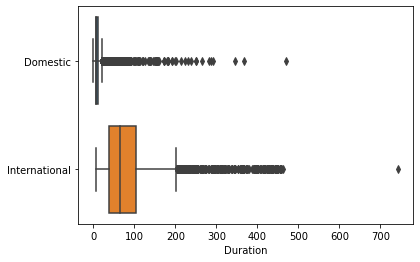

In [24]:
ax = sns.boxplot(x='Duration', y='Declarations', data=data)
plt.ylabel('')
fig = ax.get_figure()
fig.savefig('../figures/boxplot-throughput-both-800dpi.png', dpi=800, bbox_inches='tight')

### Comparing samples with statistical test

*To make conclusion on sample equality some statistical test should by performed. The most known is two-sample Student t-test. To apply this test assumptions should be true: (1) assumption on equal sample size and (2) assumption on variance similarity.*

In [25]:
print('means:', x1.mean().round(3), x2.mean().round(3))
print('variances:', x1.var().round(3), x2.var().round(3))

means: 11.675 86.452
variances: 291.677 6137.317


*Since both assumptions are violated another test should by used. We can apply Welch's t-test which allows for unequal sample size and variance. It is implemented if Python's scipy library under the name ttest_ind.*

*Null hypothesis H0 is that there is that both samples have the same mean. Alternative hypothesis H1 is that samples have different mean values. Les use significance level of 0.05.*

In [26]:
ttest_ind(x1, x2, equal_var=False)

Ttest_indResult(statistic=-75.5378201140604, pvalue=0.0)

*Since p-value is zero, which is obviously less than 0.05, null hypothesis is rejected in favour of the alternative one. Thus there is statistically significant difference between samples, therefore throughput of domestic and international declarations.*

## Outlier: longest declaration

In [27]:
df_int_decl.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount,dt
0,rv_travel permit 76455_6,STAFF MEMBER,Start trip,2016-10-05 00:00:00+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,2016-10-04 22:00:00+00:00
1,rv_travel permit 76455_7,STAFF MEMBER,End trip,2016-10-05 00:00:00+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,2016-10-04 22:00:00+00:00
2,st_step 76459_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-04-06 13:32:10+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,2017-04-06 11:32:10+00:00
3,st_step 76460_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-04-06 13:32:28+02:00,SUPERVISOR,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,2017-04-06 11:32:28+00:00
4,st_step 76461_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-04-07 13:38:14+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,2017-04-07 11:38:14+00:00


In [28]:
case_id = df2.sort_values(by=['days'], ascending=False).head(1).index.values[0]
case_id

'declaration 61184'

*Select events corresponding to particular case id*

In [29]:
df_int_selected = df_int_decl[df_int_decl['case:id'] == case_id]
df_int_selected.shape

(16, 24)

*Convert dataframe to ...*

In [30]:
df_int_selected.head(5)

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount,dt
40189,rv_travel permit 61182_6,STAFF MEMBER,Start trip,2018-04-29 00:00:00+02:00,EMPLOYEE,travel permit number 61183,declaration number 61185,582.417262,582.417262,task 427,...,organizational unit 65456,travel permit number 61183,1614.491664,declaration 61184,travel permit 61182,travel permit 61182,budget 146773,UNKNOWN,582.417262,2018-04-28 22:00:00+00:00
40190,st_step 61191_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-06-17 19:55:31+02:00,EMPLOYEE,travel permit number 61183,declaration number 61185,582.417262,582.417262,task 427,...,organizational unit 65456,travel permit number 61183,1614.491664,declaration 61184,travel permit 61182,travel permit 61182,budget 146773,UNKNOWN,582.417262,2018-06-17 17:55:31+00:00
40191,st_step 61190_0,STAFF MEMBER,Permit APPROVED by ADMINISTRATION,2018-06-17 19:56:08+02:00,ADMINISTRATION,travel permit number 61183,declaration number 61185,582.417262,582.417262,task 427,...,organizational unit 65456,travel permit number 61183,1614.491664,declaration 61184,travel permit 61182,travel permit 61182,budget 146773,UNKNOWN,582.417262,2018-06-17 17:56:08+00:00
40192,st_step 61192_0,STAFF MEMBER,Permit REJECTED by BUDGET OWNER,2018-06-19 14:02:31+02:00,BUDGET OWNER,travel permit number 61183,declaration number 61185,582.417262,582.417262,task 427,...,organizational unit 65456,travel permit number 61183,1614.491664,declaration 61184,travel permit 61182,travel permit 61182,budget 146773,UNKNOWN,582.417262,2018-06-19 12:02:31+00:00
40193,st_step 61193_0,STAFF MEMBER,Permit REJECTED by EMPLOYEE,2018-06-21 09:19:59+02:00,EMPLOYEE,travel permit number 61183,declaration number 61185,582.417262,582.417262,task 427,...,organizational unit 65456,travel permit number 61183,1614.491664,declaration 61184,travel permit 61182,travel permit 61182,budget 146773,UNKNOWN,582.417262,2018-06-21 07:19:59+00:00


In [31]:
log_selected = log_converter.apply(df_int_selected)
log_selected

[{'attributes': {'Permit travel permit number': 'travel permit number 61183', 'DeclarationNumber': 'declaration number 61185', 'Amount': 582.4172618847641, 'RequestedAmount': 582.4172618847641, 'Permit TaskNumber': 'task 427', 'Permit BudgetNumber': 'budget 1313', 'OriginalAmount': 582.4172618847641, 'Permit ProjectNumber': 'project 17142', 'concept:name': 'declaration 61184', 'Permit OrganizationalEntity': 'organizational unit 65456', 'travel permit number': 'travel permit number 61183', 'Permit RequestedBudget': 1614.4916639253001, 'id': 'declaration 61184', 'Permit ID': 'travel permit 61182', 'Permit id': 'travel permit 61182', 'BudgetNumber': 'budget 146773', 'Permit ActivityNumber': 'UNKNOWN', 'AdjustedAmount': 582.4172618847641}, 'events': [{'id': 'rv_travel permit 61182_6', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Start trip', 'time:timestamp': Timestamp('2018-04-29 00:00:00+0200', tz='UTC+02:00'), 'org:role': 'EMPLOYEE', 'dt': Timestamp('2018-04-28 22:00:00+0000', tz='U

In [32]:
dfg = dfg_discovery.apply(log_selected)

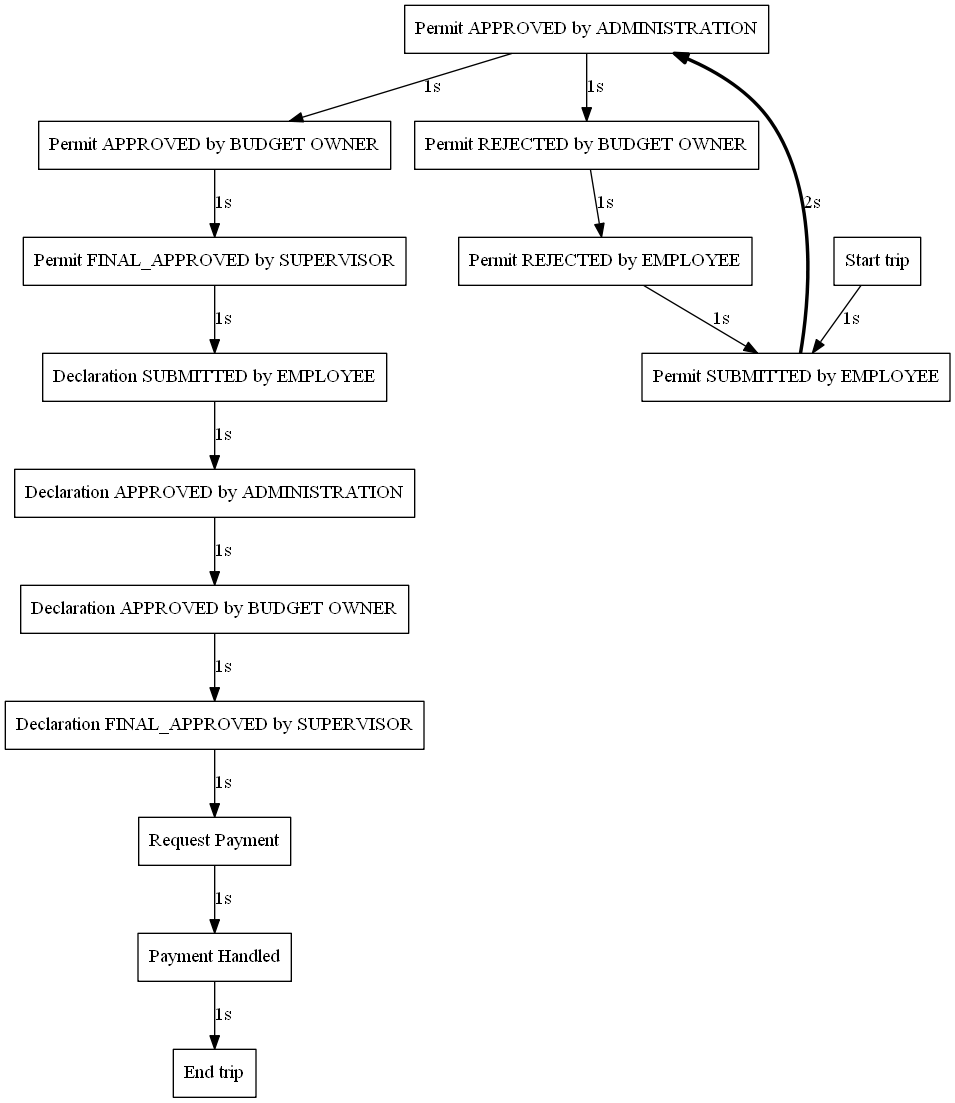

In [33]:
gviz = dfg_visualization.apply(dfg, log=log_selected, variant=dfg_visualization.Variants.PERFORMANCE)
#parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
dfg_visualization.view(gviz)
#dfg_visualization.save(gviz, "../figures/dfg_domestic_declarations_frequency.png")

## Directly-Follows Graph

In [34]:
log_domestic_declarations = xes_importer.apply('../data/DomesticDeclarations.xes_')
dfg = dfg_discovery.apply(log_domestic_declarations)

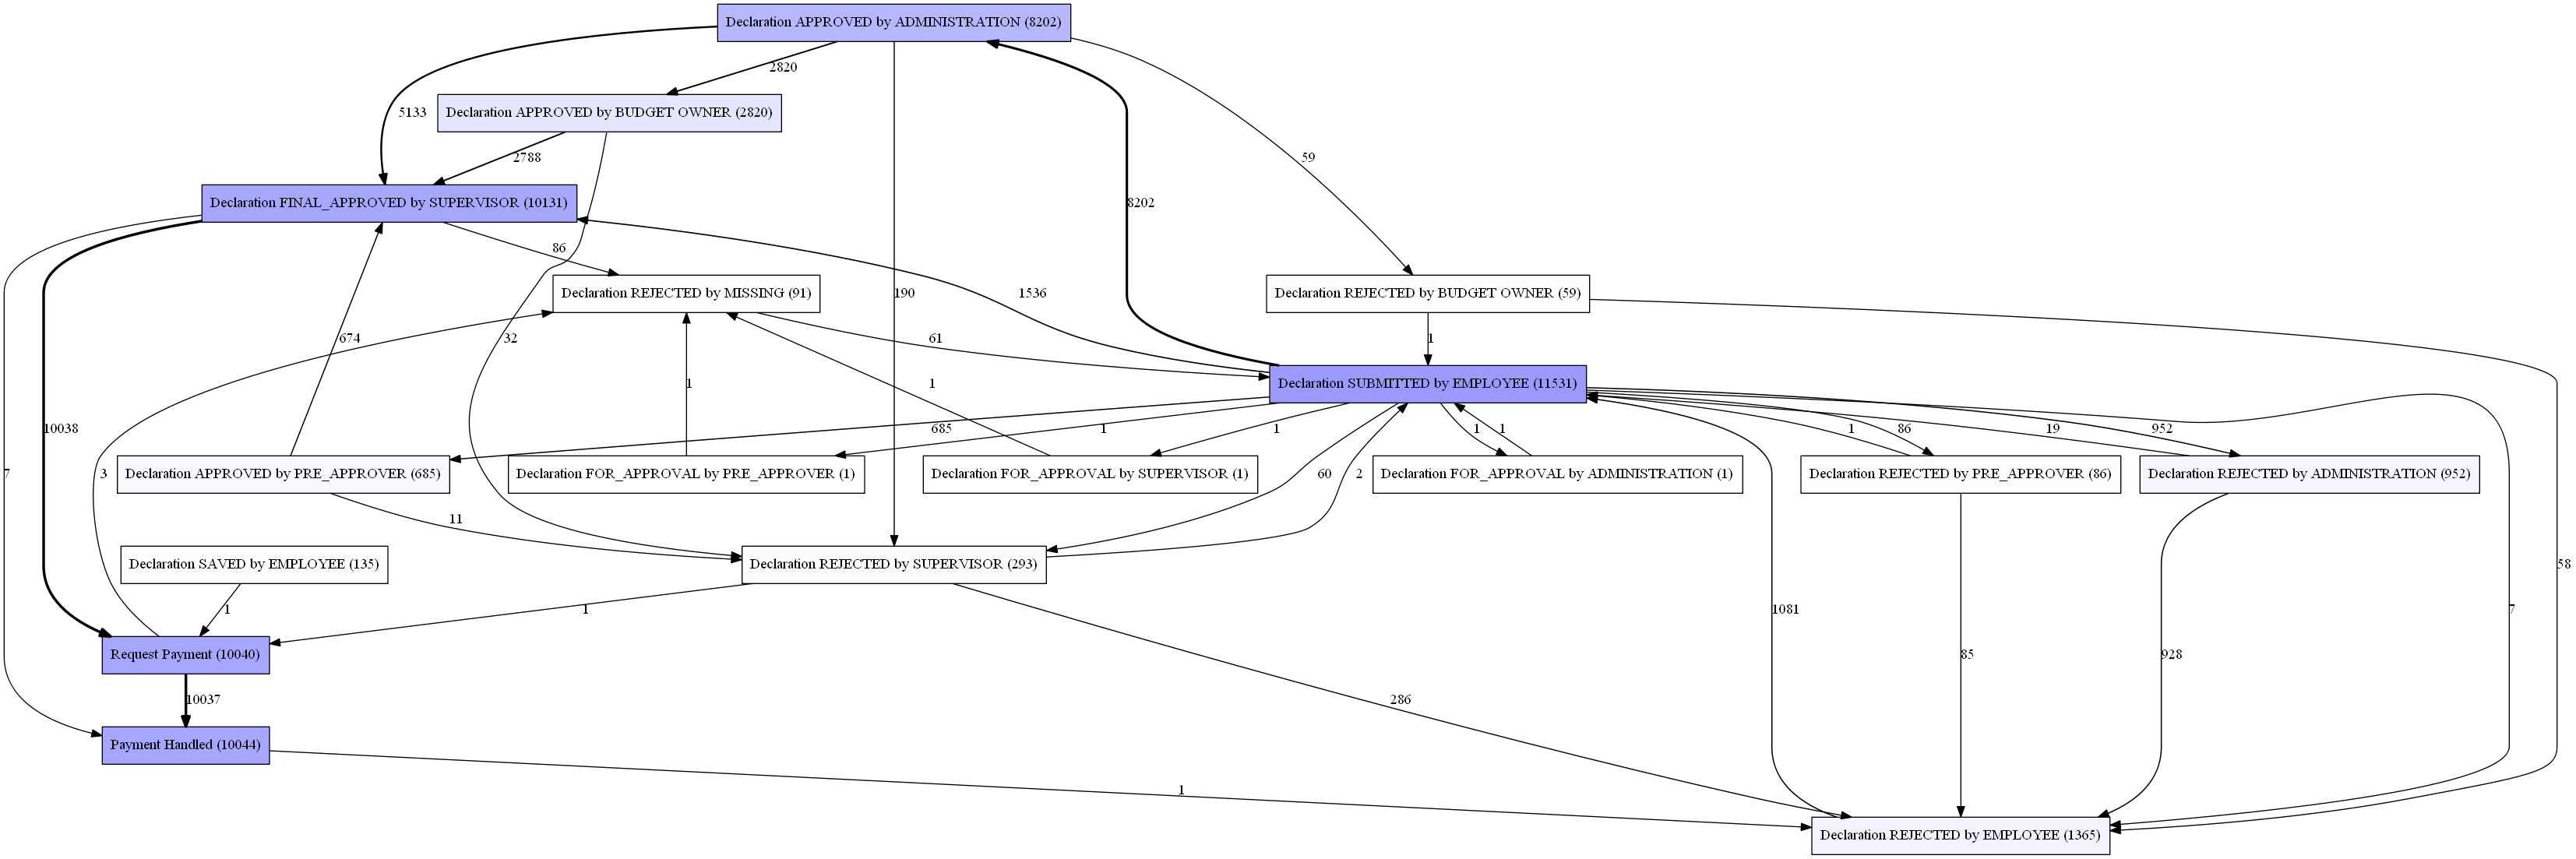

In [35]:
gviz = dfg_visualization.apply(dfg, log=log_domestic_declarations, variant=dfg_visualization.Variants.FREQUENCY)
parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "../figures/dfg_domestic_declarations_frequency.png")

In [46]:
#gviz = dfg_visualization.apply(dfg, log=log_domestic_declarations, variant=dfg_visualization.Variants.PERFORMANCE)
#parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
#dfg_visualization.view(gviz)
#dfg_visualization.save(gviz, "../figures/dfg_domestic_declarations_performance.png")

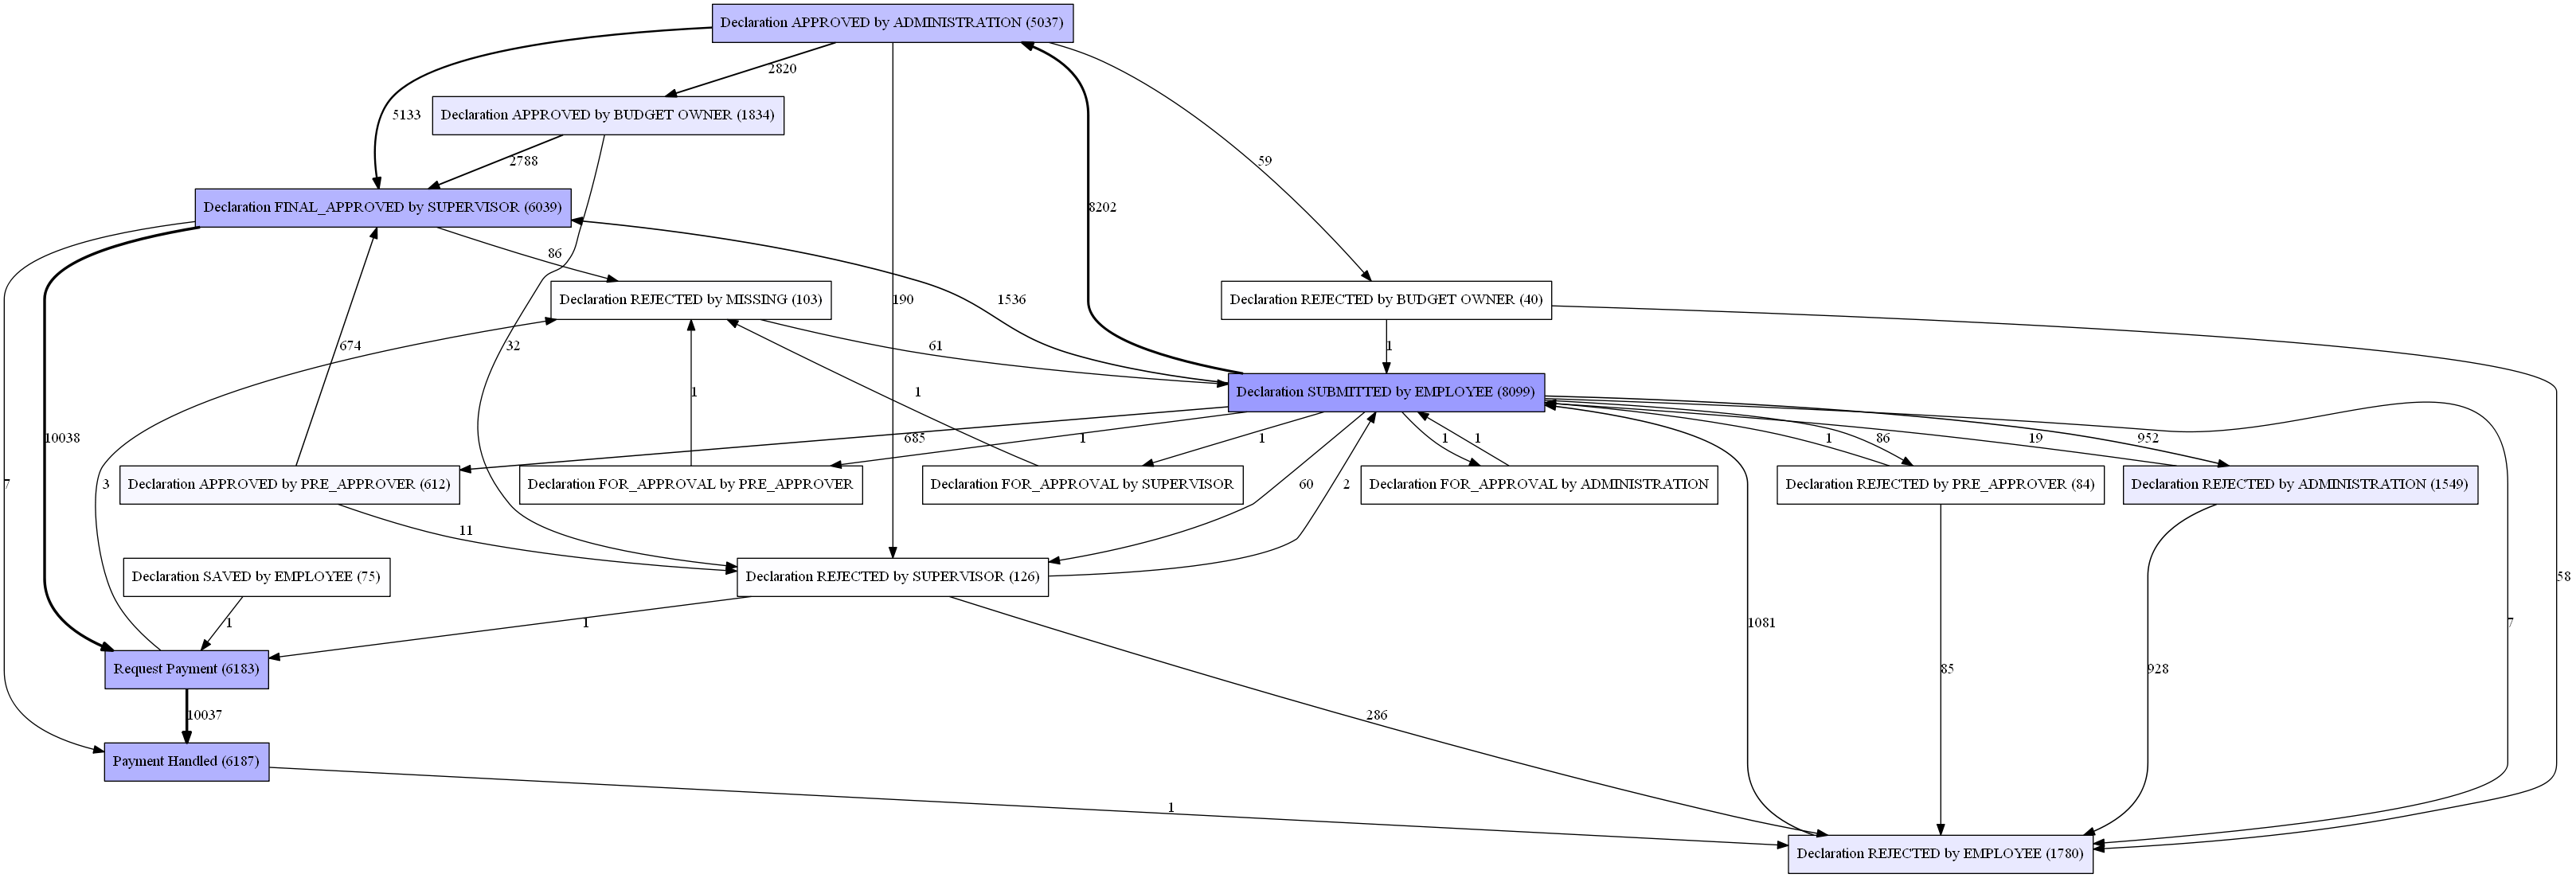

In [48]:
gviz = dfg_visualization.apply(dfg, log=log_int_decl, variant=dfg_visualization.Variants.FREQUENCY)
parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "../figures/dfg_international_declarations_frequency.png")

## Trends in duration

### Domestic flights

In [37]:
df1.head()

dt                            \
                                         min                       max   
case:id                                                                  
declaration 100000 2018-01-30 08:20:07+00:00 2018-02-12 16:31:20+00:00   
declaration 100005 2018-01-30 08:38:54+00:00 2018-02-01 16:31:17+00:00   
declaration 100010 2018-01-30 08:43:21+00:00 2018-02-01 16:31:17+00:00   
declaration 100015 2018-01-30 12:06:43+00:00 2018-02-05 16:31:02+00:00   
declaration 100021 2018-01-31 10:05:55+00:00 2018-02-12 16:31:20+00:00   

                         days  
                               
case:id                        
declaration 100000  13.341123  
declaration 100005   2.328044  
declaration 100010   2.324954  
declaration 100015   6.183553  
declaration 100021  12.267650

In [38]:
df1['start'] = df1['dt']['min']
df1 = df1[['start', 'days']]
df1['shift'] = (df1['start'] - df1['start'].min()).dt.days

In [39]:
df1.head()

,start,days,shift
,,,
case:id,,,
declaration 100000,2018-01-30 08:20:07+00:00,13.341123,385
declaration 100005,2018-01-30 08:38:54+00:00,2.328044,385
declaration 100010,2018-01-30 08:43:21+00:00,2.324954,385
declaration 100015,2018-01-30 12:06:43+00:00,6.183553,386
declaration 100021,2018-01-31 10:05:55+00:00,12.267650,387


In [40]:
x = df1['shift'].values
y = df1['days'].values
slope, intercept, _, _, _ = linregress(x, y)
slope, intercept

(-4.454994233566495e-06, 11.676793930740759)

In [41]:
start, finish = df1['start'].min(), df1['start'].max()
delta = (finish - start).days
start, finish, delta

(Timestamp('2017-01-09 08:49:50+0000', tz='UTC'),
 Timestamp('2018-12-29 16:50:14+0000', tz='UTC'),
 719)

In [42]:
v1 = intercept + slope * 0
start, v1

(Timestamp('2017-01-09 08:49:50+0000', tz='UTC'), 11.676793930740759)

In [43]:
v2 = intercept + slope * delta
finish, v2

(Timestamp('2018-12-29 16:50:14+0000', tz='UTC'), 11.673590789886825)

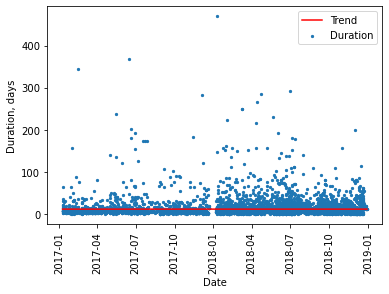

In [44]:
xx = np.array([start, finish])
yy = np.array([v1, v2])
fig, ax = plt.subplots()
ax.scatter(df1['start'], df1['days'], s=5, label='Duration')
ax.plot(xx, yy, c='red', label='Trend')
plt.legend()
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Duration, days")
plt.show()
fig.savefig('../figures/scatter-drift-date-duration-domestic-800dpi.png', dpi=800, bbox_inches='tight')

In [45]:
slope * delta

-0.00320314085393431

*Conclusion: there is no drift in throughput*

### International flights

In [49]:
df2.head()

dt                            \
                                        min                       max   
case:id                                                                 
declaration 1002  2018-03-01 09:55:17+00:00 2018-04-09 15:30:58+00:00   
declaration 10024 2018-02-20 12:51:27+00:00 2018-04-23 15:31:11+00:00   
declaration 10026 2018-02-20 12:51:27+00:00 2018-04-23 15:31:11+00:00   
declaration 10046 2018-02-20 12:53:11+00:00 2018-05-17 15:31:34+00:00   
declaration 10069 2018-02-21 15:28:17+00:00 2018-03-01 16:31:26+00:00   

                        days  
                              
case:id                       
declaration 1002   39.233113  
declaration 10024  62.110926  
declaration 10026  62.110926  
declaration 10046  86.109988  
declaration 10069   8.043854

In [50]:
df2['start'] = df2['dt']['min']
df2 = df2[['start', 'days']]
df2['shift'] = (df2['start'] - df2['start'].min()).dt.days

In [51]:
df2.head()

,start,days,shift
,,,
case:id,,,
declaration 1002,2018-03-01 09:55:17+00:00,39.233113,512
declaration 10024,2018-02-20 12:51:27+00:00,62.110926,503
declaration 10026,2018-02-20 12:51:27+00:00,62.110926,503
declaration 10046,2018-02-20 12:53:11+00:00,86.109988,503
declaration 10069,2018-02-21 15:28:17+00:00,8.043854,504


In [52]:
x = df2['shift'].values
y = df2['days'].values
slope, intercept, _, _, _ = linregress(x, y)
slope, intercept

(-0.15644950957123777, 166.76566288104226)

In [53]:
start, finish = df2['start'].min(), df2['start'].max()
delta = (finish - start).days
start, finish, delta

(Timestamp('2016-10-04 22:00:00+0000', tz='UTC'),
 Timestamp('2018-12-14 13:08:53+0000', tz='UTC'),
 800)

In [54]:
v1 = intercept + slope * 0
start, v1

(Timestamp('2016-10-04 22:00:00+0000', tz='UTC'), 166.76566288104226)

In [55]:
v2 = intercept + slope * delta
finish, v2

(Timestamp('2018-12-14 13:08:53+0000', tz='UTC'), 41.60605522405204)

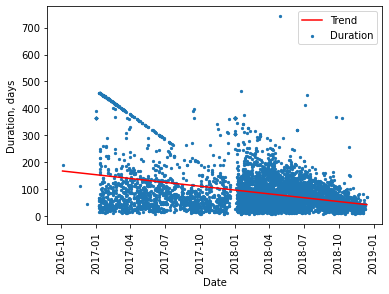

In [56]:
xx = np.array([start, finish])
yy = np.array([v1, v2])
fig, ax = plt.subplots()
ax.scatter(df2['start'], df2['days'], s=5, label='Duration')
ax.plot(xx, yy, c='red', label='Trend')
plt.legend()
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Duration, days")
plt.show()
fig.savefig('../figures/scatter-drift-date-duration-international-800dpi.png', dpi=800, bbox_inches='tight')

In [ ]:
slope * delta

*Conclusion: there is significant drift in throughput for international declarations*

## 3 Results

- answers were given
- EDA performed
- models where built
- outliers were found
- suggestions were made
- tools: Python 3.8.0, PM4Py 1.4.0, seaborn 

*Q01: significant difference, ...*

To reproduce our solution

In [ ]:
# pm4py.__version__

In [ ]:
sns.__version__

# References

1. arxive 1905.06169 url: https://arxiv.org/pdf/1905.06169.pdf
1. van der Aalst, Wil. Process Mining Data Science in Action 
1. pm4py docs url: https://pm4py.fit.fraunhofer.de/docs
1. SciPy Reference Guide: https://docs.scipy.org/doc/scipy/reference/genindex.html